In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from datetime import datetime
import seaborn as sns

#### Load Dataset

In [2]:
df = pd.read_csv("datasets/data_perm_take_home.csv", encoding="ISO-8859-1")

In [3]:
def map_date(date_str):
    if type(date_str) != str:
        return None
    return datetime.strptime(date_str, "%m/%d/%y").date()

df.case_received_date = df.case_received_date.apply(map_date)
df.decision_date = df.decision_date.apply(map_date)

In [4]:
df.head()

,case_number,case_received_date,decision_date,case_status,employer_name,employer_num_employees,employer_yr_established,job_education,job_experience_num_months,job_state,job_foreign_lang_req,job_level,employee_citizenship,wage_offer,wage_unit
0,A-06191-36805,2014-12-22,2015-06-19,Certified,BRENTWOOD BIOMEDICAL RESEARCH INSTITUTE,149.0,1988.0,Bachelor's,NaN,CALIFORNIA,N,1.0,RUSSIA,30285.0,Year
1,A-07194-56311,2014-12-19,2015-06-19,Denied,WASHINGTON STATE UNIVERSITY,5600.0,1890.0,Doctorate,NaN,WASHINGTON,N,2.0,RUSSIA,150000.0,Year
2,A-07194-56513,2014-12-17,2015-06-19,Certified,WASHINGTON STATE UNIVERSITY,5600.0,1890.0,Doctorate,NaN,WASHINGTON,N,2.0,INDIA,125000.0,Year
3,A-07194-56514,2014-10-09,2015-03-03,Certified,WASHINGTON STATE UNIVERSITY,5600.0,1890.0,Doctorate,84.0,WASHINGTON,N,3.0,CANADA,105300.0,Year
4,A-07197-57029,2014-10-06,2015-03-03,Certified,WASHINGTON STATE UNIVERSITY,5600.0,1890.0,Doctorate,NaN,WASHINGTON,N,1.0,ARGENTINA,114285.0,Year


#### Load Database into MySQL Server

In [5]:
from sqlalchemy import create_engine

In [6]:
username = "shaw"
password = "1234"
port = 8888
database = "Case"

engine = create_engine('mysql+mysqldb://%s:%s@localhost:%i/%s'
                       %(username, password, port, database))

In [7]:
df.to_sql('Perm', engine, if_exists='replace')

### Part I: Short Question
__Q1__: Which employer has the most entries in the dataset?

__Ans__: COGNIZANT TECHNOLOGY SOLUTIONS US CORPORATION

In [8]:
sql = """
SELECT employer_name, COUNT(*) entry_count 
FROM Perm 
GROUP BY employer_name 
ORDER BY entry_count 
DESC LIMIT 5;
"""
pd.read_sql_query(sql.replace('\n', " ").replace("\t", " "), engine)

,employer_name,entry_count
0,COGNIZANT TECHNOLOGY SOLUTIONS US CORPORATION,5441
1,INTEL CORPORATION,1611
2,"CISCO SYSTEMS, INC.",1028
3,GOOGLE INC.,914
4,QUALCOMM TECHNOLOGIES INC.,862


__Q2__: Which employer has the most “Certified-Expired” cases?

__Ans__: MICROSOFT CORPORATION

In [9]:
sql = """
SELECT employer_name, COUNT(*) AS cert_expired_count 
FROM Perm 
WHERE case_status = "Certified-Expired"
GROUP BY employer_name 
ORDER BY cert_expired_count 
DESC LIMIT 5;
"""
pd.read_sql_query(sql.replace('\n', " ").replace("\t", " "), engine)

,employer_name,cert_expired_count
0,MICROSOFT CORPORATION,521
1,"CISCO SYSTEMS, INC.",398
2,QUALCOMM TECHNOLOGIES INC.,269
3,GOOGLE INC.,253
4,AMAZON CORPORATE LLC,231


__Q3__: How many unique employers contain the character string "APPLE" that is not "APPLE INC."?

__Ans__: 7

In [10]:
sql = """
SELECT DISTINCT employer_name
FROM Perm
WHERE employer_name LIKE "%%APPLE%%" 
  AND employer_name != "APPLE INC.";
"""
df_q3 = pd.read_sql_query(sql.replace('\n', " ").replace("\t", " "), engine)
print("Number of unique employers contain the character string APPLE that is not APPLE INC: %i"%len(df_q3))
df_q3

Number of unique employers contain the character string APPLE that is not APPLE INC: 7


,employer_name
0,APPLETREE EARLY LEARNING PUBLIC CHARTER SCHOOLS
1,APPLEXUS TECHNOLOGIES LLC
2,APPLETON GRP LLC
3,APPLE EDUCATIONAL SERVICES
4,BIG APPLE EDUCATION CENTER INC.
5,APPLE FEDERAL CREDIT UNION
6,apple seeds LLC


__Q4__: Write a function that plots a histogram with 50 bins of the duration between from case_received_date
to decision_date for any given employeer_name. Use the function to plot for "APPLE INC." and "GOOGLE INC."

In [11]:
def plot_processing_time_for_company(employer_name):
    sql = """
    SELECT 
      decision_date
      ,case_received_date
      ,DATEDIFF(decision_date, case_received_date) AS duration
    FROM Perm 
    WHERE employer_name = "%s";
    """%employer_name
    
    df_duration = pd.read_sql_query(sql.replace('\n', " ").replace("\t", " "), engine)
    
    plt.hist(df_duration.duration, bins=50)
    plt.xlabel("days between received and decision")
    plt.ylabel("frequency")
    plt.title(employer_name)
    plt.show()

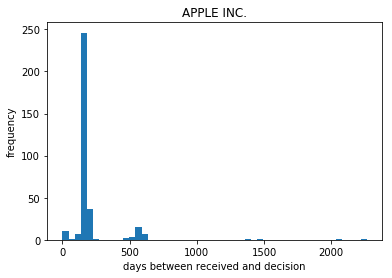

In [12]:
plot_processing_time_for_company("APPLE INC.")

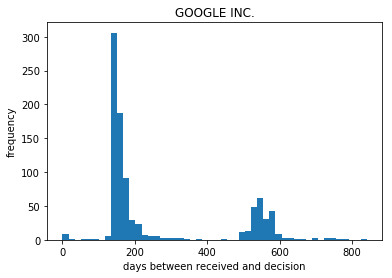

In [13]:
plot_processing_time_for_company("GOOGLE INC.")